## Read clinical and protein data, divide into folds

In [ ]:
import numpy as np
import pandas as pd
# path to ClinicalDemographics.csv
df_clin = pd.read_csv('ClinicalDemographics.csv')
# create new column GroupUpdated
df_clin['GroupUpdated'] = np.where(
    (df_clin['TimeYears_CT_blood'] == 0) & (df_clin['Group'] == 'Lung_Cancer'), 'Lung_Cancer',
    np.where(
        df_clin['Group'] == 'Benign_Nodules', 'Benign_Nodules',
        np.where(
            df_clin['Group'] == 'False_Positive', 'False_Positive',
            np.where(
                df_clin['Group'] == 'Control', 'Control',
                'IndeterminatePreLungCancer'  # For other cases (including Lung_Cancer with TimeYears_blood ≠ 0)
            )
        )
    )
)
df_clin['Cancer_Status'] = np.where(df_clin['Group'] == 'Lung_Cancer', 1, 0)

In [ ]:
# read excel
# path to Olink_proteomics.xlsx
df_prot = pd.read_excel('Olink_proteomics.xlsx', skiprows=2) # define path
# delete rows 0,1,2
df_prot = df_prot.iloc[3:]

In [ ]:
import os
import nrrd
# read image data to save NRRD_File and SEG_Files paths
destination_root = "LDCT_data" # read path to data
# Initialize lists to store dimensions and results
dimensions_list = []
dimension_check_results = []

# Walk through the destination root directory
for group_name in os.listdir(destination_root):
    group_path = os.path.join(destination_root, group_name)
    if os.path.isdir(group_path):
        for patient_id in os.listdir(group_path):
            patient_path = os.path.join(group_path, patient_id)
            if os.path.isdir(patient_path):
                nrrd_file_path = None
                seg_file_path = None
                
                for file_name in os.listdir(patient_path):
                    if file_name.endswith('.nrrd') and '_seg' not in file_name:
                        nrrd_file_path = os.path.join(patient_path, file_name)
                    elif file_name.endswith('.nrrd') and ('_seg' in file_name):
                        seg_file_path = os.path.join(patient_path, file_name)
                
                if nrrd_file_path and seg_file_path:
                    try:
                        nrrd_data, nrrd_header = nrrd.read(nrrd_file_path)
                        seg_data, seg_header = nrrd.read(seg_file_path)
                        
                        nrrd_dimensions = nrrd_data.shape
                        seg_dimensions = seg_data.shape

                        dimensions_list.append(nrrd_dimensions)
                        dimensions_list.append(seg_dimensions)

                        if nrrd_dimensions == seg_dimensions:
                            result = "Dimensions match"
                        else:
                            result = "Dimensions do not match"
                    except Exception as e:
                        result = f"Error reading files: {e}"
                else:
                    result = "Missing nrrd or seg file"
                
                dimension_check_results.append({
                    "Group": group_name,
                    "ID_patient": patient_id,
                    "NRRD_File": nrrd_file_path,
                    "SEG_File": seg_file_path,
                    "NRRD_Dimensions": nrrd_dimensions if nrrd_file_path else None,
                    "SEG_Dimensions": seg_dimensions if seg_file_path else None,
                    "Result": result
                })

# Create a DataFrame from the results
df_dimension_check_results = pd.DataFrame(dimension_check_results)

# Calculate max and min dimensions
if dimensions_list:
    dimensions_array = np.array(dimensions_list)
    max_dimensions = dimensions_array.max(axis=0)
    min_dimensions = dimensions_array.min(axis=0)

    print(f"Maximum dimensions: {max_dimensions}")
    print(f"Minimum dimensions: {min_dimensions}")
else:
    print("No dimensions to calculate max and min values.")

Maximum dimensions: [512 512 647]
Minimum dimensions: [512 512 106]


In [4]:
# df_dimension_check_results to dataframe format
df_dimension_check_results = pd.DataFrame(dimension_check_results)
# join df_clin and df_dimension_check_results[['ID_patient', 'NRRD_File', 'SEG_File']] on ID_patient
# convert ID_patient to number without decimal, then to str
df_clin['ID_patient'] = df_clin['ID_patient'].astype(float).astype(int)
df_clin['ID_patient'] = df_clin['ID_patient'].astype(str)
df_clin = pd.merge(df_clin, df_dimension_check_results[['ID_patient', 'NRRD_File', 'SEG_File']], on='ID_patient', how='left')

In [5]:
# join df_clin with df_prot on ID_patient
df_merged_raw = pd.merge(df_clin, df_prot, left_on='ID_patient', right_on='ID_patient', how='inner')
df_merged_raw.shape
# save df_merged to csv in path_to_df_merged
# df_merged_raw.to_csv('', index=False)

(211, 1140)

In [6]:
df_merged_raw['Group_stage'] = df_merged_raw['GroupUpdated']
df_merged_raw.loc[df_merged_raw['Group_stage'] == 'Lung_Cancer', 'Group_stage'] = df_merged_raw.apply(
    lambda x: f'Lung_Cancer_{x["Stage_category"]}' if pd.notna(x['Stage_category']) else 'Lung_Cancer', axis=1
)

## Split data into 3 folds

/home/ubuntu/tenerife/data/ZZ_githubRepos/LungAmbition_Dataset/DataPreparation/stratified_fold_GroupAgeSexStageSmokingTimeCancerDiag.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cur['Group_stage'] = df_cur['GroupUpdated']
/home/ubuntu/tenerife/data/ZZ_githubRepos/LungAmbition_Dataset/DataPreparation/stratified_fold_GroupAgeSexStageSmokingTimeCancerDiag.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cur['Age_Group'] = pd.cut(df_cur['Age'], bins=bins, labels=labels, right=False)
/home/ubun

Plots saved to plots/fold_1_distribution.pdf


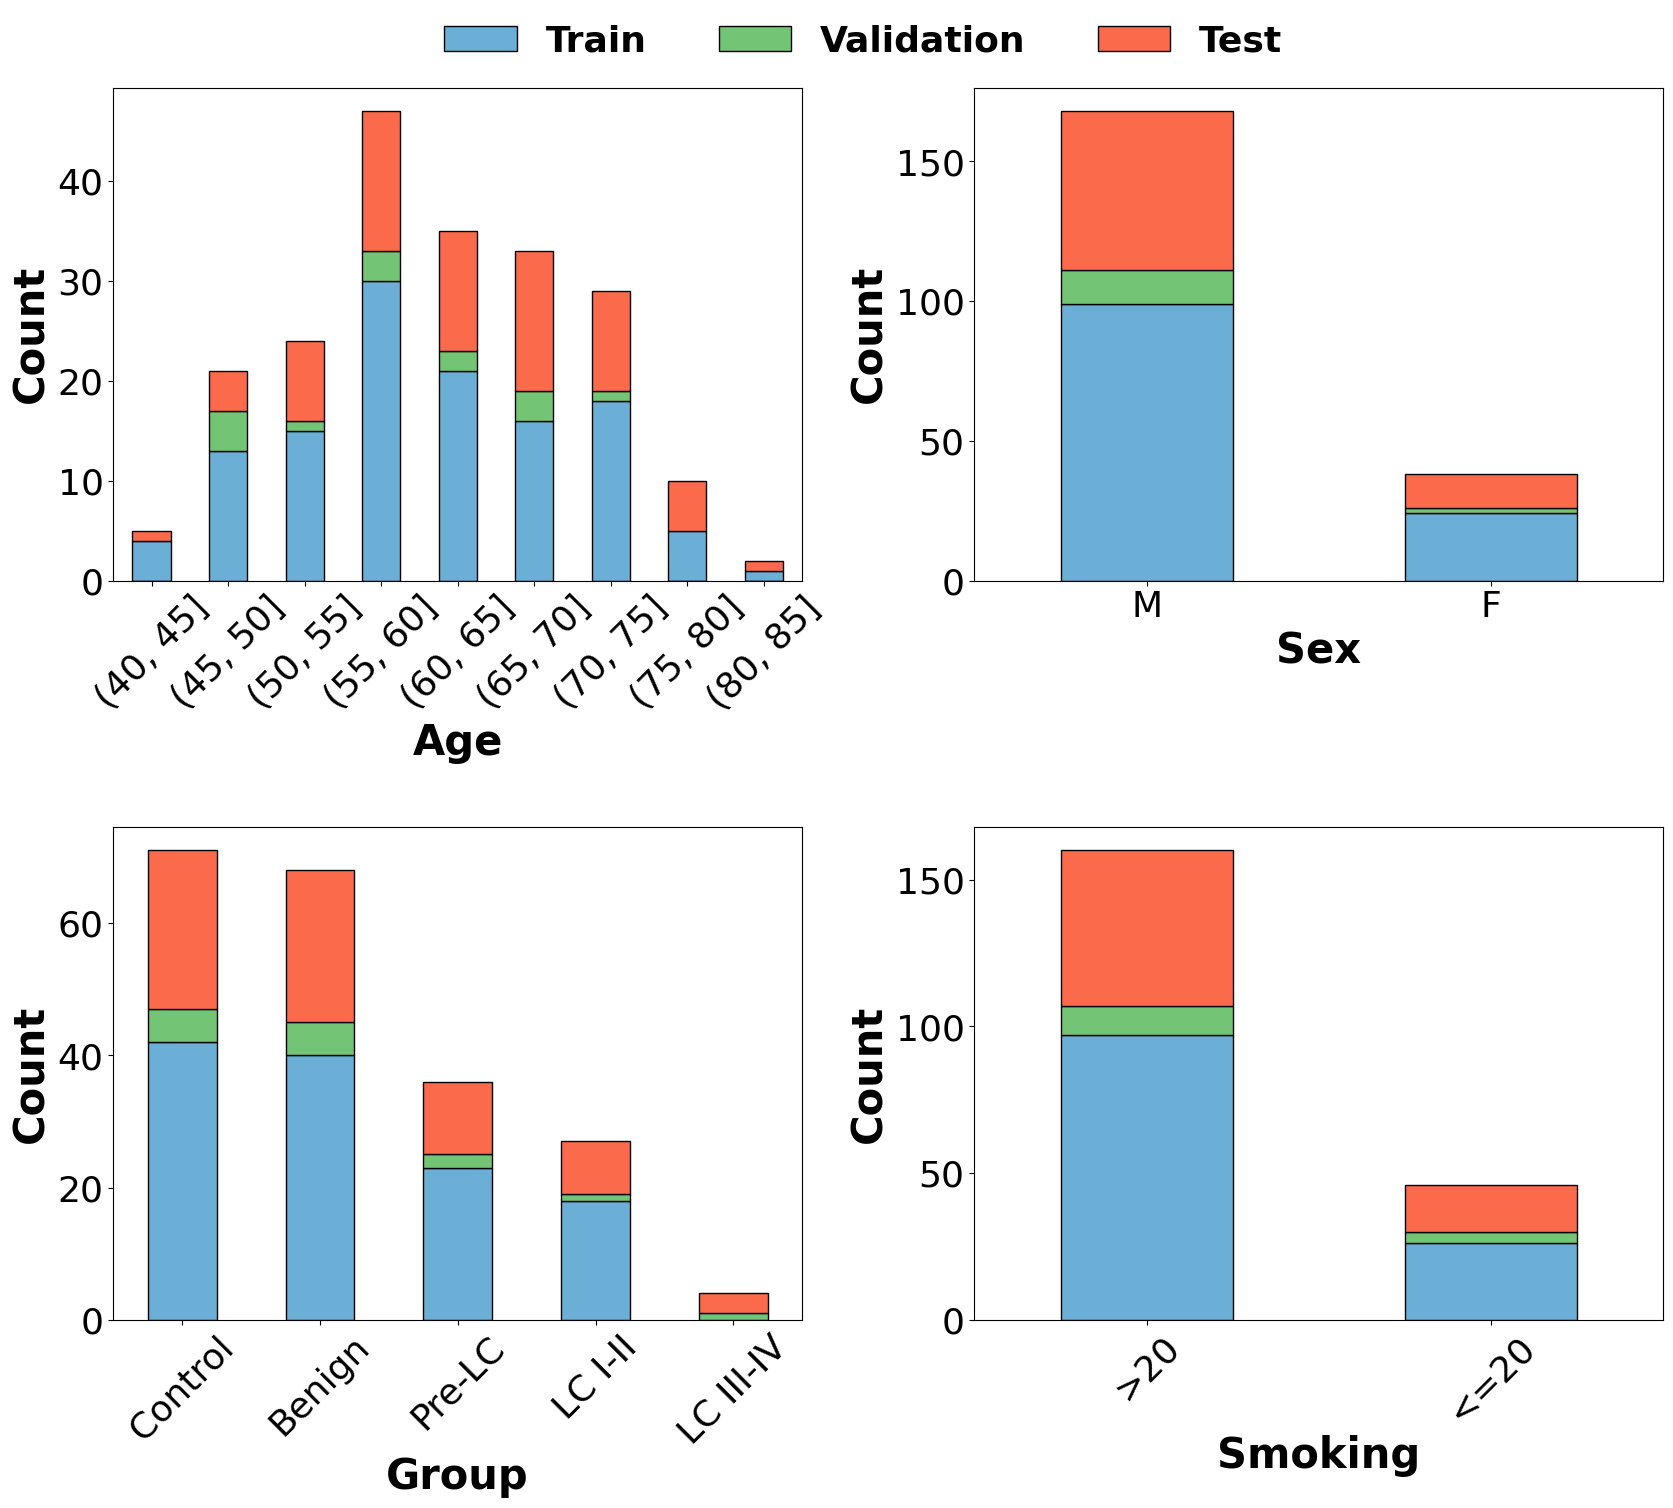

/home/ubuntu/tenerife/data/ZZ_githubRepos/LungAmbition_Dataset/DataPreparation/stratified_fold_GroupAgeSexStageSmokingTimeCancerDiag.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_stage"] = df["Group_stage"].replace(rename_categories)


Plots saved to plots/fold_2_distribution.pdf


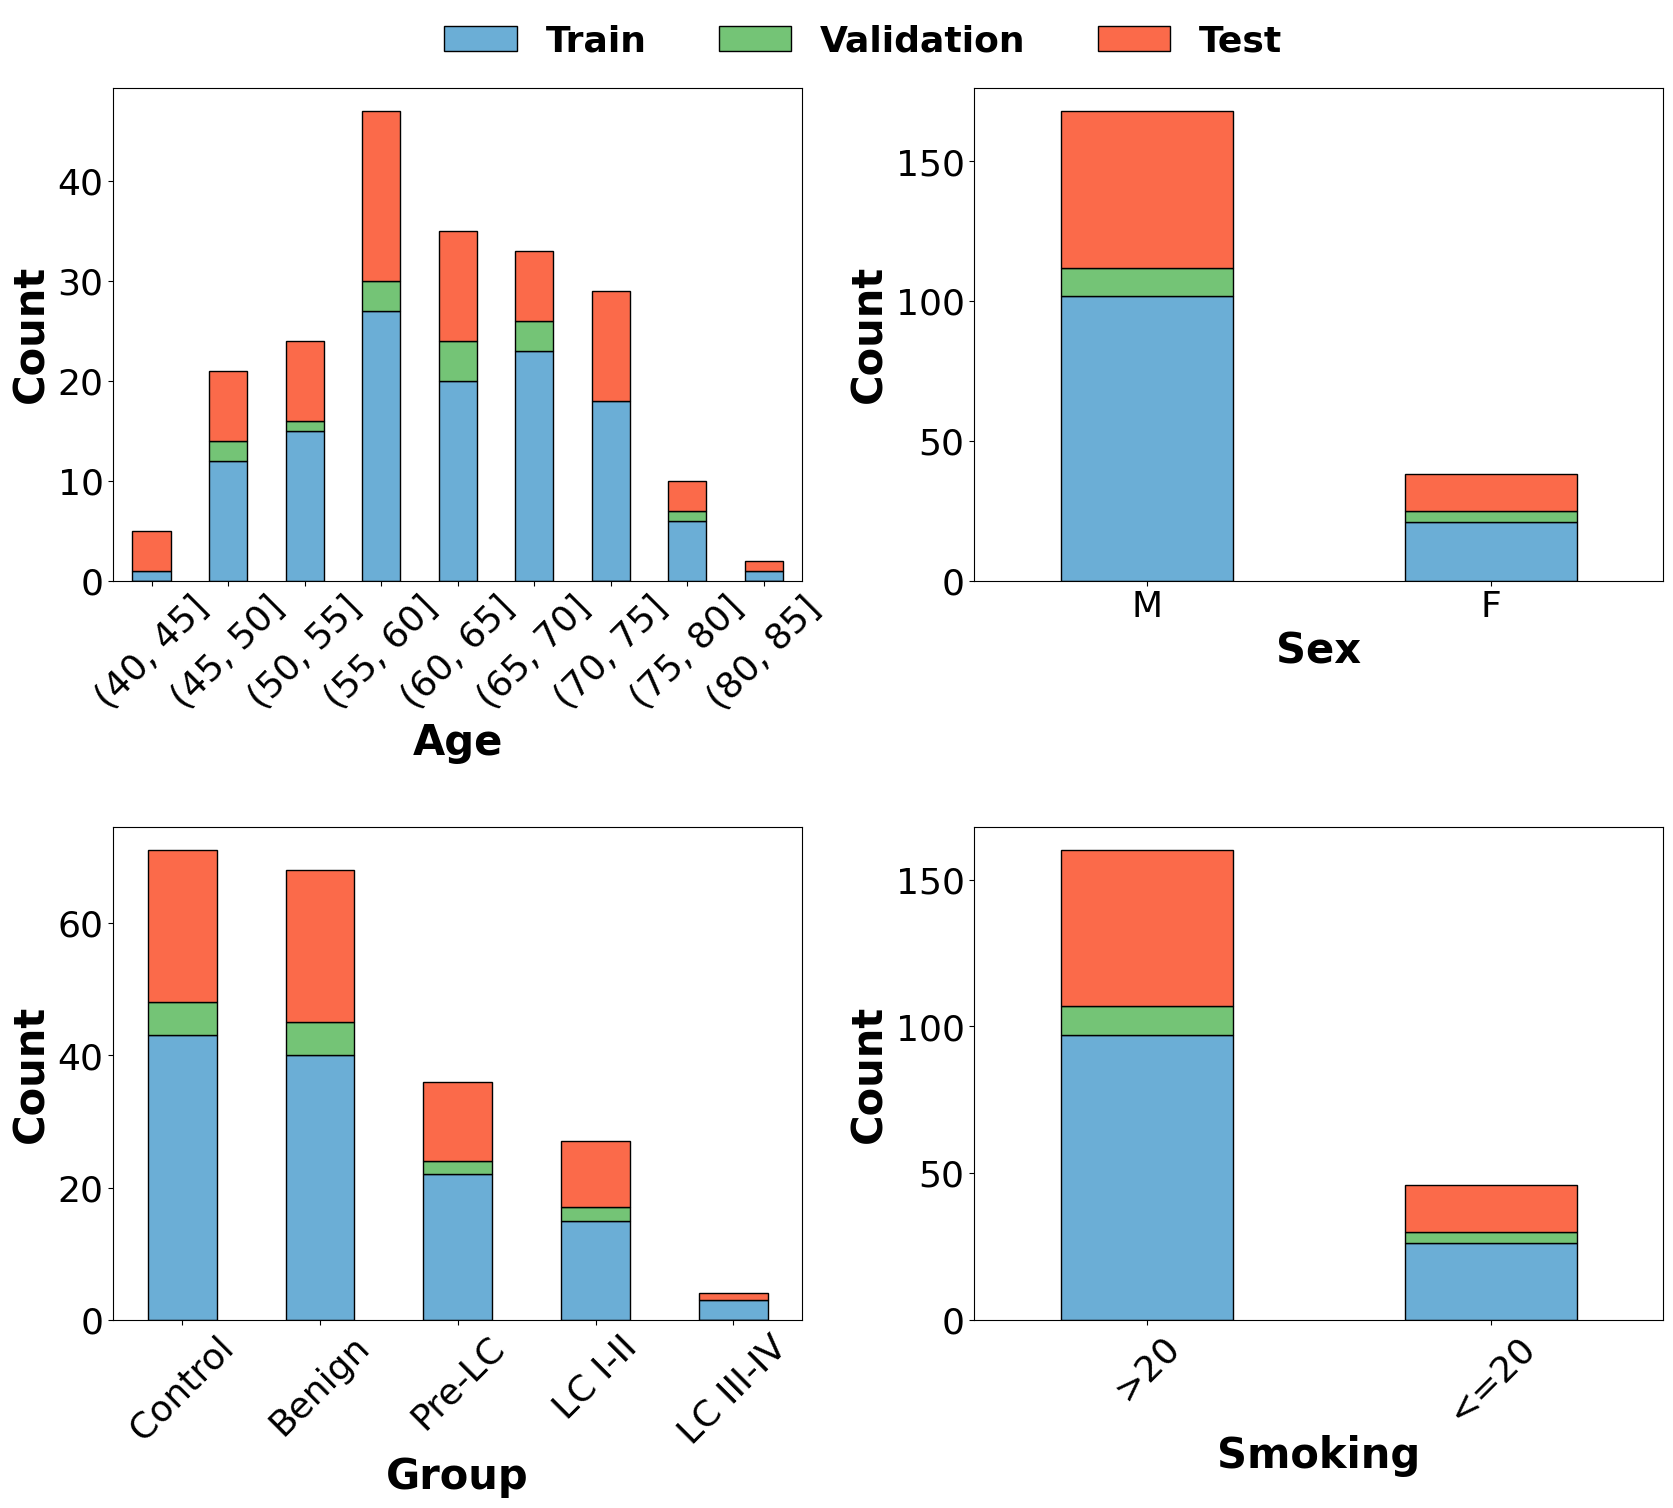

/home/ubuntu/tenerife/data/ZZ_githubRepos/LungAmbition_Dataset/DataPreparation/stratified_fold_GroupAgeSexStageSmokingTimeCancerDiag.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_stage"] = df["Group_stage"].replace(rename_categories)


Plots saved to plots/fold_3_distribution.pdf


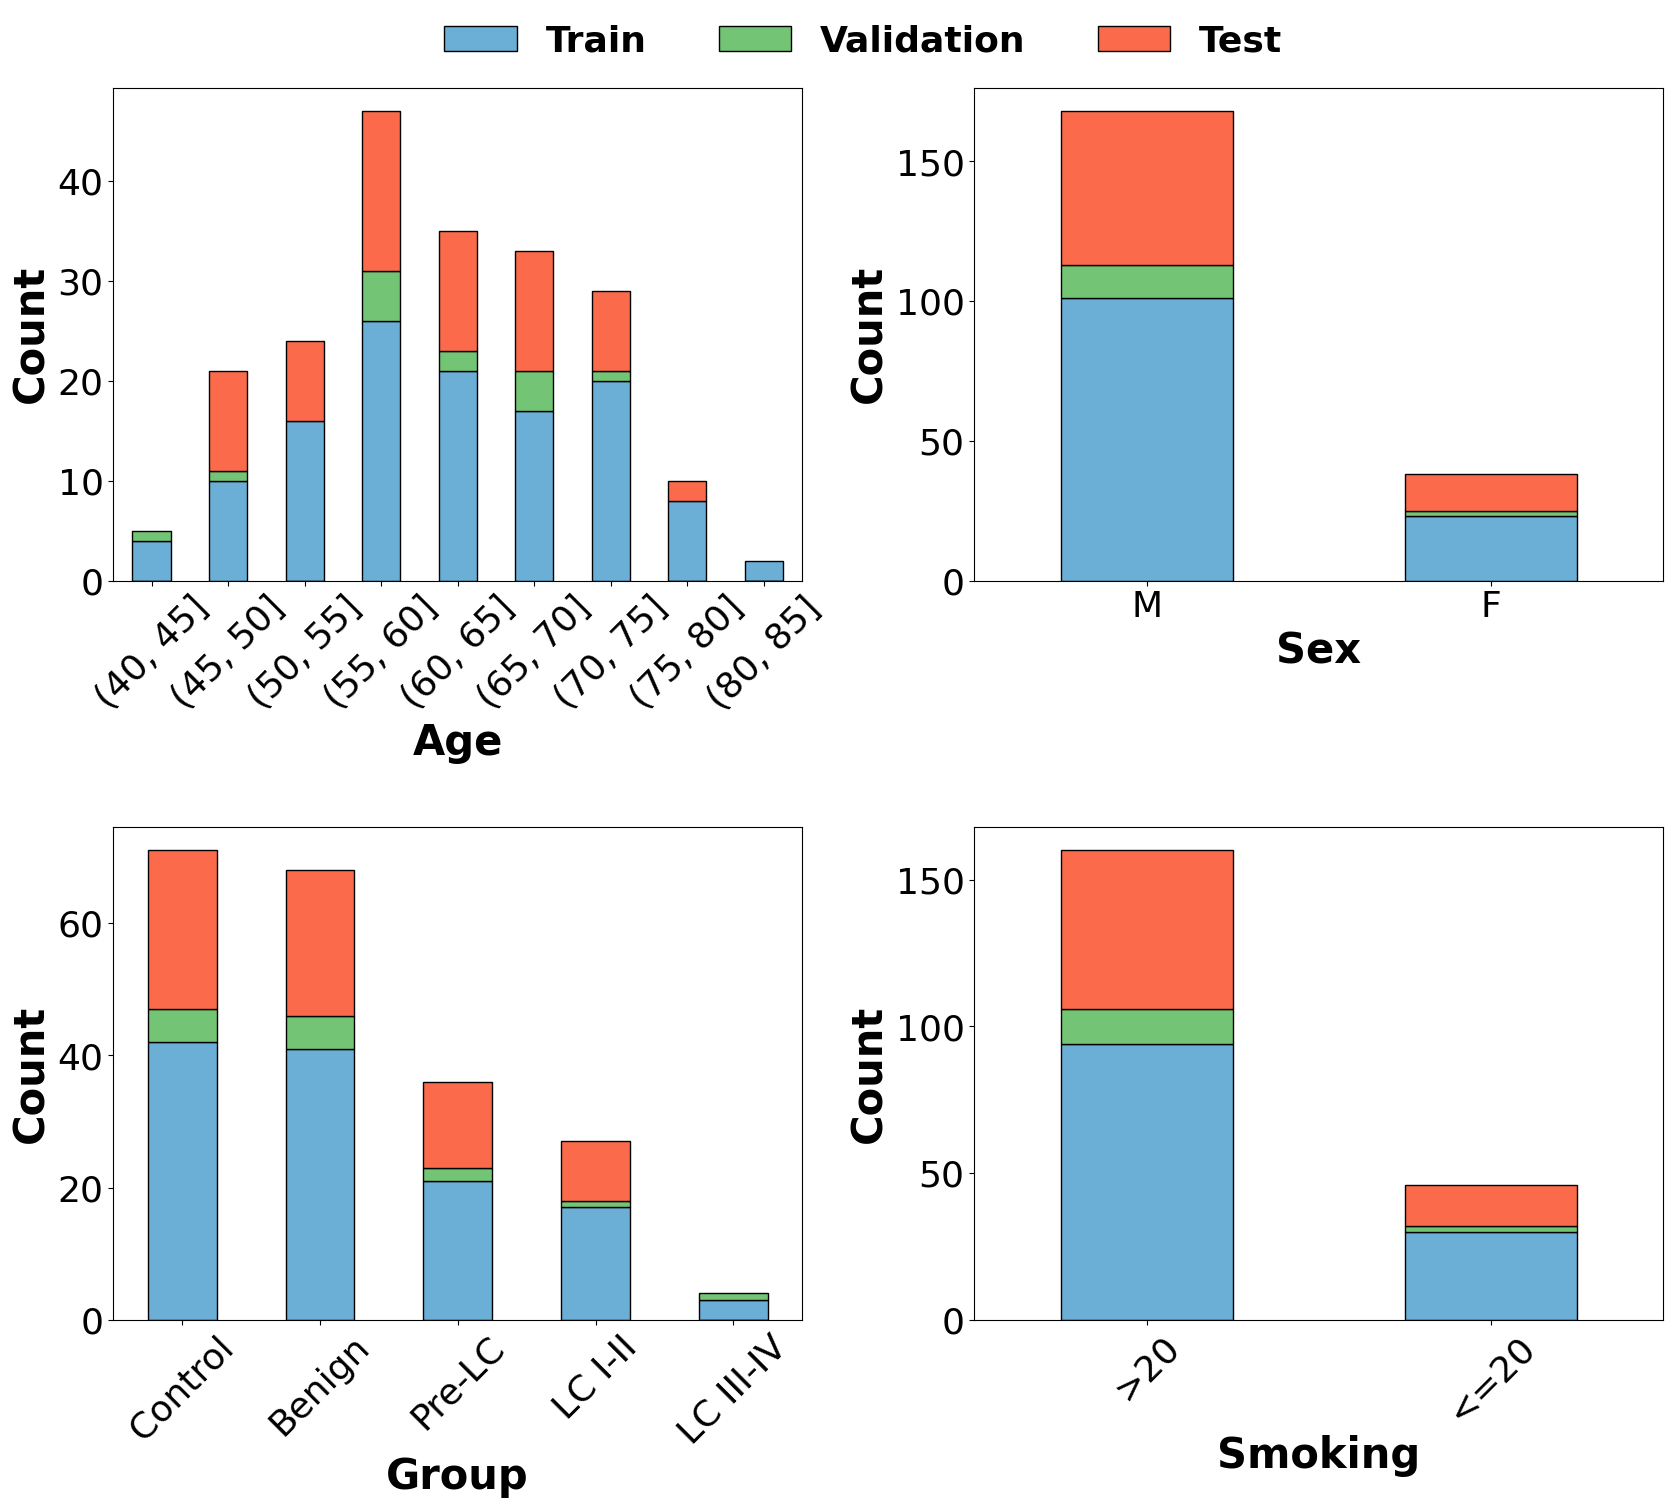

Fold 1:
Training data: (123, 1138) (123,) Non cancer patients train: 0 Lung cancer patients train: 0
Validation data: (14, 1138) (14,) Non cancer patients val: 0 Lung cancer patients val: 0
Test data: (69, 1138) (69,) Non cancer patients test: 0 Lung cancer patients test: 0


/tmp/ipykernel_1147725/2471573943.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['split'] = 'train'
/tmp/ipykernel_1147725/2471573943.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['split'] = 'val'
/tmp/ipykernel_1147725/2471573943.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

FileNotFoundError: [Errno 2] No such file or directory: ''

In [7]:
from stratified_fold_GroupAgeSexStageSmokingTimeCancerDiag import create_stratified_folds, plot_distributions
import torch
import os
output_folder = '' # define
path_to_save_plots = os.path.join(output_folder, 'plots')
# select only in Group Lung_Cancer and Benign_Nodules
df_merged = df_merged_raw[df_merged_raw['GroupUpdated'].isin(['Lung_Cancer', 'Benign_Nodules', 'Control', 'IndeterminatePreLungCancer'])]

# get column to predict Group
y_target = df_merged['GroupUpdated']
# # encode y
# y_target = y_target.replace({'Lung_Cancer': 1, 'Benign_Nodules': 0, 'Control': 0})

# get features, all except Group and ID_patient column
X = df_merged.drop(['GroupUpdated', 'Group', 'ID_patient'], axis=1)

age_range = 5
bins = list(range(40, 90, age_range))
labels = [f'{start}-{start + age_range -1}' for start in bins[:-1]]
fold_data = create_stratified_folds(df_merged, bins, labels, n_splits=3, random_state=1, val_split=0.10)
plot_distributions(df_merged, fold_data, bins, save_plots=True, output_folder=path_to_save_plots)

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Iterate over the folds
for fold, indices in fold_data.items():
    print(f"Fold {fold + 1}:")
    train_index = indices['train_index']
    test_index = indices['test_index']
    val_index = indices['val_index']
    X_train, X_test, X_val = X.iloc[train_index], X.iloc[test_index], X.iloc[val_index]
    y_train, y_test, y_val = y_target.iloc[train_index], y_target.iloc[test_index], y_target.iloc[val_index]
    print("Training data:", X_train.shape, y_train.shape, "Non cancer patients train:", len(y_train[y_train == 0]), "Lung cancer patients train:", len(y_train[y_train == 1]))
    print("Validation data:", X_val.shape, y_val.shape, "Non cancer patients val:", len(y_val[y_val == 0]), "Lung cancer patients val:", len(y_val[y_val == 1]))
    print("Test data:", X_test.shape, y_test.shape, "Non cancer patients test:", len(y_test[y_test == 0]), "Lung cancer patients test:", len(y_test[y_test == 1]))
    df_split = pd.DataFrame()

    # Add train data
    train_data = df_merged.iloc[indices['train_index']]
    train_data['split'] = 'train'

    # Add validation data
    val_data = df_merged.iloc[indices['val_index']]
    val_data['split'] = 'val'

    # Add test data
    test_data = df_merged.iloc[indices['test_index']]
    test_data['split'] = 'test'

    # Add False_Positive data as 'test_false_positive'
    test_false_positive = df_merged_raw[df_merged_raw['GroupUpdated'] == 'False_Positive']
    test_false_positive['split'] = 'test_false_positive'

    # convert to int and to strin ID_patient
    train_data['ID_patient'] = train_data['ID_patient'].astype(int).astype(str)
    val_data['ID_patient'] = val_data['ID_patient'].astype(int).astype(str)
    test_data['ID_patient'] = test_data['ID_patient'].astype(int).astype(str)
    test_false_positive['ID_patient'] = test_false_positive['ID_patient'].astype(int).astype(str)

    # Concatenate all data for the fold
    df_fold = pd.concat([train_data[['ID_patient', 'GroupUpdated', 'Cancer_Status',
                                            'TimeYears_CT_blood', 'TimeMonths_CT_blood', 'split']],
                         val_data[['ID_patient', 'GroupUpdated', 'Cancer_Status',
                                            'TimeYears_CT_blood', 'TimeMonths_CT_blood', 'split']],
                         test_data[['ID_patient', 'GroupUpdated', 'Cancer_Status',
                                            'TimeYears_CT_blood', 'TimeMonths_CT_blood', 'split']],
                         test_false_positive[['ID_patient', 'Cancer_Status', 'GroupUpdated',
                                            'TimeYears_CT_blood', 'TimeMonths_CT_blood', 'split']]])

    # Save the fold data to a CSV file
    # create output_folder if does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    fold_csv_path = os.path.join(output_folder, f'id2splitfold_{fold}.csv')
    df_fold.to_csv(fold_csv_path, index=False)
    print(f"Fold {fold} saved to {fold_csv_path}")